In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import seaborn as sns
pd.set_option("display.max_colwidth", 0)
# from IPython.core.display import display, HTML
# display(HTML("<style>div.output_scroll { height: 100em; }</style>"))


In [2]:
raw_data = pd.read_csv("play_sessions.csv")

In [3]:
len(raw_data)

953

In [4]:
raw_data = raw_data[raw_data.user_id.notnull()]
raw_data = raw_data[raw_data.version == "1.0.3"]
raw_data = raw_data.reset_index()
len(raw_data)

619

![diagram](diagram.png)

In [5]:
class Episode():
    def __init__(self):
        self.passing = False
        self.programming_interface = pd.DataFrame()
        self.episode_data = pd.DataFrame()
        self.program = ""
        self.challenge_name = ""
    def __init__(self, pi:pd.DataFrame, ed:pd.DataFrame, passing:bool, program_rep:str, challenge_name:str):
        self.passing = passing
        self.programming_interface = pi
        self.episode_data = ed
        self.program = program_rep
        self.challenge_name = challenge_name
    def __str__(self):
        return str(ed)
        

In [6]:
def parse_raw_data_frames(row:int) -> pd.DataFrame:
    frames = raw_data.frames[row]
    obj = json.loads(frames)
    for i, o in enumerate(obj):
        obj[i] = json.loads(obj[i])
    session = pd.DataFrame(obj)
    return session

memo_frames = {}

def iter_session_frames():
    for i in raw_data.index:
        if i not in memo_frames:   
            frames = parse_raw_data_frames(i)
            memo_frames[i] = frames
        yield memo_frames[i].copy()

def iter_enum_session_frames(): #TODO: uh make this not a weird copy
    for i in raw_data.index:
        yield i, parse_raw_data_frames(i)

In [7]:
organized_sessions = defaultdict(list)
other_actors = pd.DataFrame()

for i, all_frames in iter_enum_session_frames():
    if len(all_frames) == 0:
        continue
    user_id = raw_data.user_id[i]
    
    episode_list = []
    passing = False
    state = ""
    challenge_name = ""
    curr_prog_interface = pd.DataFrame(columns=all_frames.columns)
    prev_prog_interface = pd.DataFrame(columns=all_frames.columns)
    curr_episode_data = pd.DataFrame(columns=all_frames.columns)
    for i, frame in all_frames.iterrows():
        if frame.actor == "episode_data":
            if frame.object_name == "challenge_pass":
                passing = True
            if frame.verb == "episode_started":
                challenge_name = frame.object_name
                episode_list.append(Episode(passing=passing, pi=prev_prog_interface, ed=curr_episode_data, program_rep=state, challenge_name=challenge_name))
                state = json.dumps(json.loads(frame.state_info["program"]), sort_keys=True)
                passing = False
                prev_prog_interface = curr_prog_interface
                curr_prog_interface = pd.DataFrame(columns=all_frames.columns)
                curr_episode_data = pd.DataFrame(columns=all_frames.columns)
                
            curr_episode_data.loc[i] = frame
        elif frame.actor == "programming_interface":
            curr_prog_interface.loc[i] = frame
        else:
            other_actors = pd.concat([other_actors, frame.to_frame(1).T],  ignore_index=True, sort=True)
    # record last episode and last program changes
    episode_list.append(Episode(passing=passing, pi=prev_prog_interface, ed=curr_episode_data, program_rep=state, challenge_name=challenge_name))
    if len(curr_prog_interface) > 0:
        episode_list.append(Episode(passing=False, pi=curr_prog_interface, ed=pd.DataFrame(columns=all_frames.columns), program_rep="", challenge_name=challenge_name))
        
    organized_sessions[user_id].append(episode_list)
    

In [8]:
heatmap_ratio = pd.DataFrame() # rows are user id, columns are session, values are episode pass rate
heatmap_tries = pd.DataFrame()
# TODO: assumption is that user runs each challenge once

for user_id, sessions_list in organized_sessions.items():
    for i, session in enumerate(sessions_list):
        if len(session) > 0:
            challenge = session[0].challenge_name
        else:
            challenge = "no episodes"
        num_unique_starts = 0
        num_unique_passes = 0
        for j, episode in enumerate(session):
            if episode.program != "":
                if num_unique_starts == 0:
                    num_unique_starts += 1
                    if episode.passing:
                        num_unique_passes += 1
                else:
                    if episode.program != session[j-1].program:
                        num_unique_starts += 1
                        if episode.passing:
                            num_unique_passes += 1
        if num_unique_starts != 0:
            heatmap_ratio.loc[user_id,challenge] = num_unique_passes / num_unique_starts
            
        else:
            heatmap_ratio.loc[user_id,challenge] = -1
        heatmap_tries.loc[user_id,challenge] = num_unique_starts


In [9]:
# heatmap_data = heatmap_data.reindex(sorted(heatmap_data.columns), axis=1)
heatmap_ratio

,spike_curric_turning_in_place_curriculum,spike_curric_turning_in_place_left_turn_try_it,spike_curric_90_degree_turn_try_it,,spike_curric_advertising_challenge,spike_curric_adjust_pixel_brightness_try_it,spike_curric_write_your_own_message_try_it,spike_curric_smile_mini_challenge,spike_curric_sound_commands_curriculum,spike_curric_sequential_tones,...,spike_curric_move_until_hard_pressed_try_it,spike_curric_move_until_pressed_starting_point_try_it,spike_curric_arm_wait_until_try_it,spike_curric_vacuum_mini_challenge,spike_curric_exploring_a_disaster_site_challenge,spike_curric_light_commands_curriculum,spike_curric_programing_a_sequence,spike_curric_other_turns_with_steering_curriculum,spike_curric_wait_until_near_change_threshold_try_it,spike_curric_getting_started_curriculum
1923583.0,1.0,1.0,1.000000,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1927377.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947069.0,0.5,1.0,0.500000,-1.0,0.5,0.5,0.5,0.5,0.5,0.5,...,0.0,1.000,1.0,0.500000,0.00,NaN,NaN,NaN,NaN,NaN
1927379.0,0.0,1.0,1.000000,-1.0,NaN,0.5,0.5,1.0,0.0,0.5,...,0.0,0.875,1.0,0.000000,0.00,1.0,1.0,1.0,1.0,NaN
1947080.0,NaN,NaN,NaN,-1.0,NaN,1.0,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1947078.0,1.0,1.0,1.000000,-1.0,0.5,1.0,1.0,1.0,1.0,1.0,...,0.0,1.000,0.0,1.000000,0.00,1.0,1.0,0.5,1.0,NaN
1947084.0,0.5,1.0,1.000000,-1.0,0.5,1.0,0.5,NaN,1.0,1.0,...,0.0,1.000,0.5,0.000000,0.00,1.0,0.0,1.0,1.0,NaN
1927404.0,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947087.0,1.0,1.0,1.000000,-1.0,NaN,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.5,NaN,NaN
1947124.0,NaN,1.0,1.000000,-1.0,0.0,1.0,1.0,1.0,0.5,NaN,...,0.0,NaN,1.0,0.000000,1.00,NaN,1.0,1.0,NaN,NaN


Text(158.22222222222223, 0.5, 'user id')

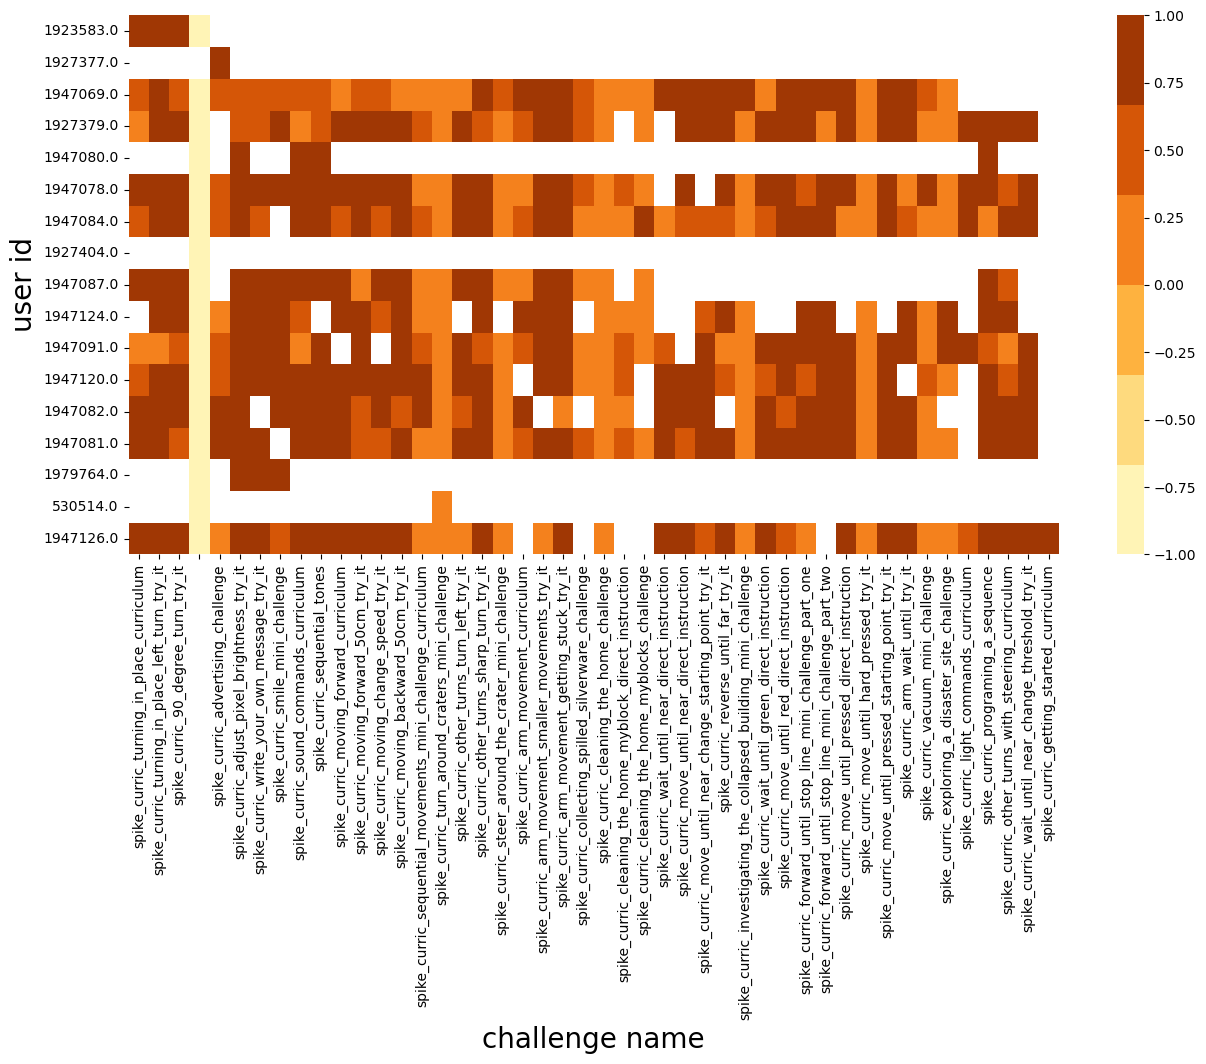

In [10]:
plt.figure(figsize=(15,7))
p = sns.heatmap(heatmap_ratio,
           cmap=sns.color_palette("YlOrBr"))
p.set_xlabel("challenge name", fontsize = 20)
p.set_ylabel("user id", fontsize = 20)

Text(158.22222222222223, 0.5, 'user id')

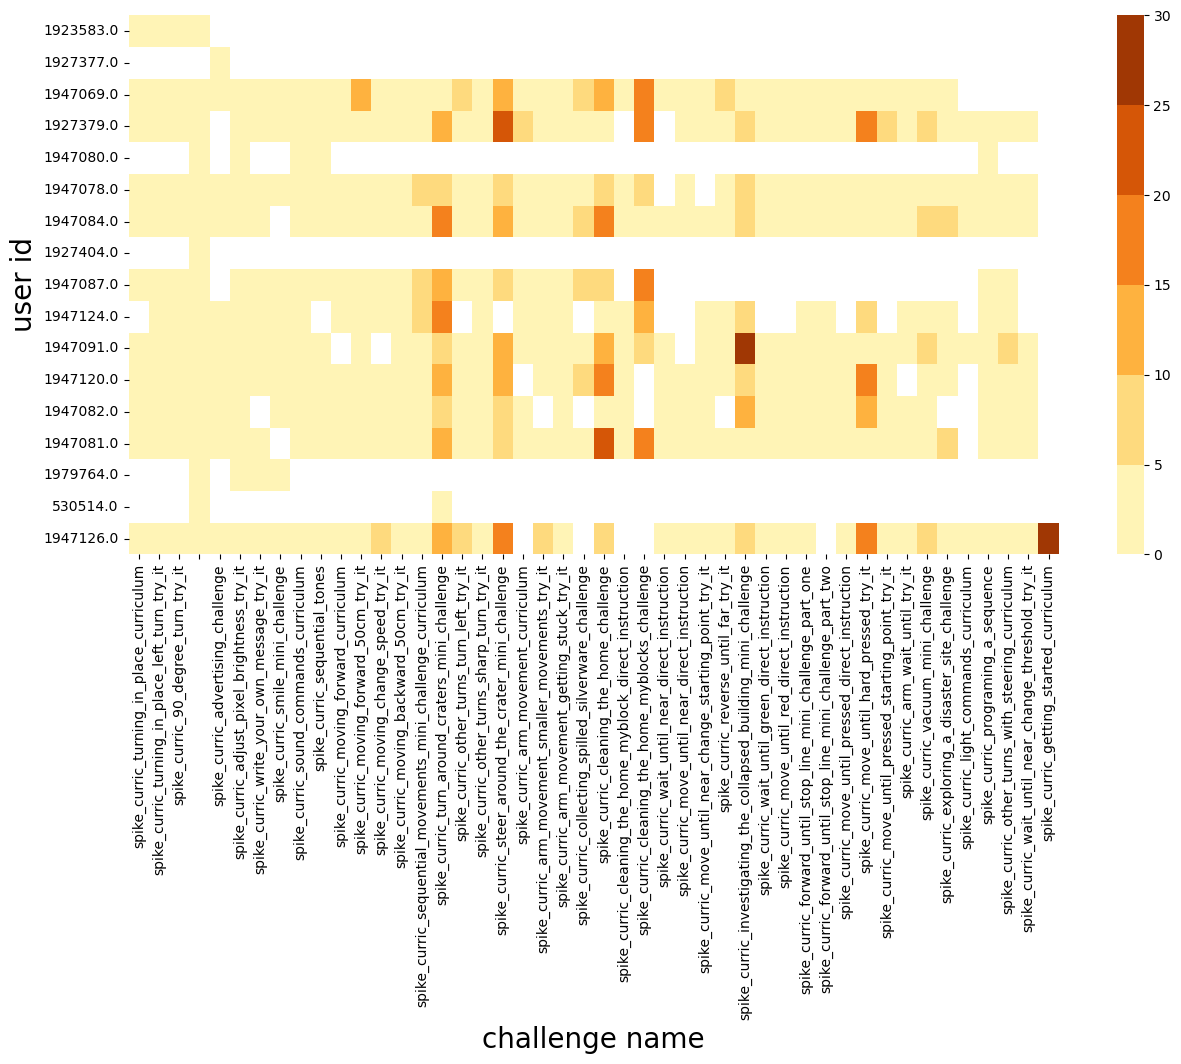

In [11]:
plt.figure(figsize=(15,7))
p = sns.heatmap(heatmap_tries,
           cmap=sns.color_palette("YlOrBr"))
p.set_xlabel("challenge name", fontsize = 20)
p.set_ylabel("user id", fontsize = 20)

Text(170.72222222222223, 0.5, 'user id')

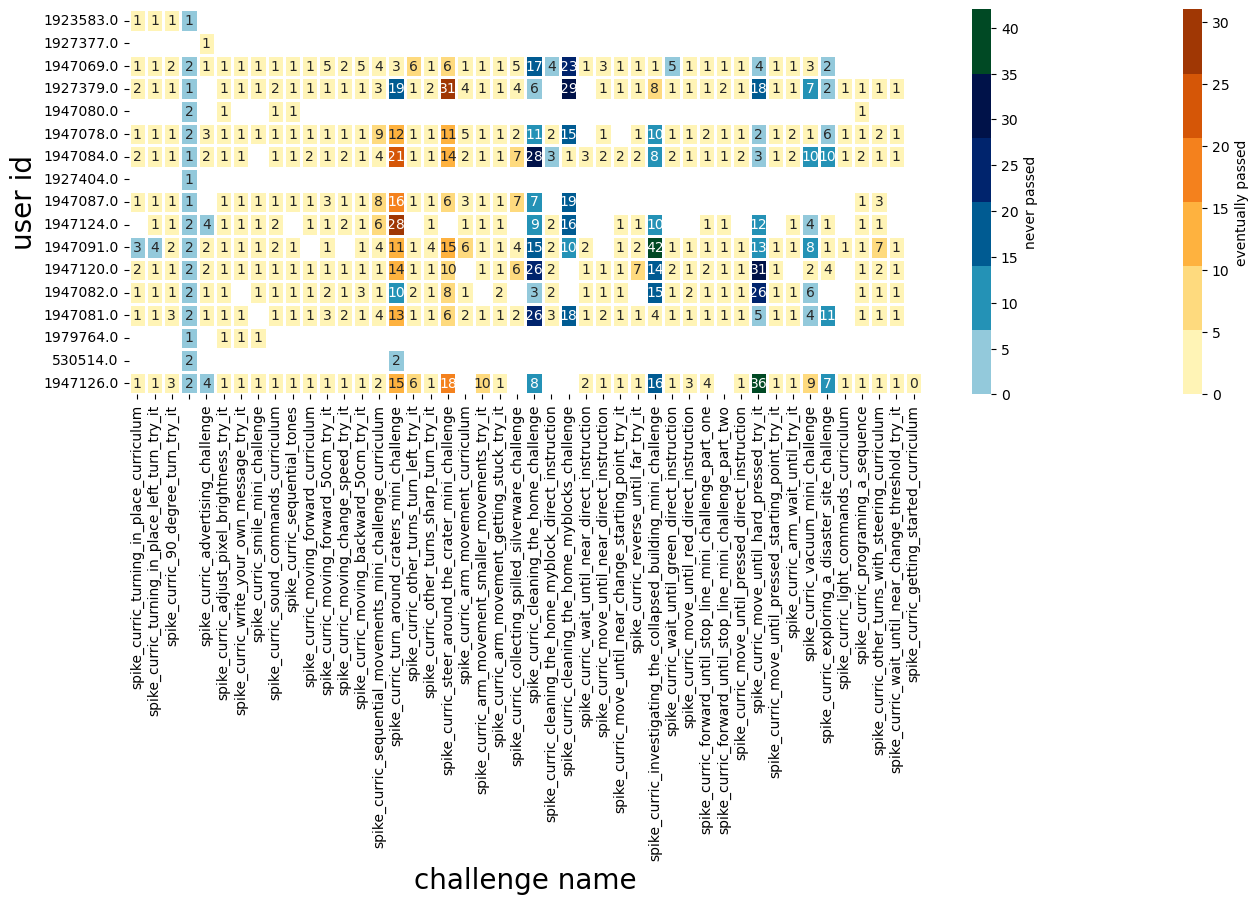

In [16]:
# for each challenge, how many attempts before the passing attempt?

def failing_attempt_counter(list_of_episodes) -> (int, bool):
    counter = 0
    for episode in list_of_episodes:
        if episode.passing:
            return counter, True
        else:
            counter += 1
    return counter, False

heatmap_failing_tries = pd.DataFrame() # rows are user id, columns are session, values are episode pass rate
heatmap_eventually_passed = pd.DataFrame()

for user_id, sessions_list in organized_sessions.items():
    for i, session in enumerate(sessions_list):
        if len(session) > 0:
            challenge = session[0].challenge_name
        else:
            challenge = "no episodes"

        numattempts, passed = failing_attempt_counter(session)
        heatmap_failing_tries.loc[user_id,challenge] = numattempts
        heatmap_eventually_passed.loc[user_id,challenge] = passed
        
heatmap_eventually_passed[:] = heatmap_eventually_passed[:].astype(bool)
plt.figure(figsize=(16,5))
p = sns.heatmap(heatmap_failing_tries, cbar_kws={'label': "eventually passed"},
           cmap=sns.color_palette("YlOrBr"), vmin=0, annot=True, linewidths=1, mask=~heatmap_eventually_passed)
p = sns.heatmap(heatmap_failing_tries, cbar_kws={'label': "never passed"},
           cmap=sns.color_palette("ocean_r"), vmin=0, annot=True, linewidths=1, mask=heatmap_eventually_passed)
p.set_xlabel("challenge name", fontsize = 20)
p.set_ylabel("user id", fontsize = 20)

# for user_id, sessions_list in organized_sessions.items():
#     fig, ax = plt.subplots(1, len(sessions_list), sharey=True)
#     for i, session in enumerate(sessions_list):
#         if len(session) > 0:
#             challenge_name = session[0].challenge_name
#         else:
#             challenge_name = ""
#         ax[i].title.set_text(challenge_name)
        
#         ax[i].histogram([failing_attempt_counter(session)])

In [22]:
def find_session(userid:int, challengename:str) -> list:
    for session in reversed(organized_sessions[userid]):
        if len(session) > 0 and session[0].challenge_name == challengename:
            return session
    return []

In [23]:
for episode in find_session(1927379, "spike_curric_turn_around_craters_mini_challenge")